# Customer Segmentation Analysis: RFM & K-Means Clustering
**Disusun oleh: Regu Tulip**

---

## 1. Latar Belakang & Tujuan Bisnis
Dalam industri *e-commerce* yang sangat kompetitif, memperlakukan semua pelanggan dengan cara yang sama adalah strategi yang tidak efisien. Pelanggan memiliki kebiasaan belanja, frekuensi, dan daya beli yang berbeda-beda.

Dalam *Capstone Project* ini, **kami bertujuan untuk**:
1.  Mengidentifikasi segmen pelanggan yang berbeda berdasarkan perilaku transaksi historis.
2.  Menggunakan metode **RFM (Recency, Frequency, Monetary)** sebagai kerangka kerja analisis.
3.  Menerapkan algoritma **K-Means Clustering** untuk mengelompokkan pelanggan secara otomatis.
4.  Memberikan **rekomendasi bisnis yang actionable** untuk meningkatkan retensi dan penjualan pada setiap segmen.

## 2. Tentang Dataset
Data yang kami gunakan adalah dataset transaksi ritel online transnasional yang berbasis di UK (01/12/2010 hingga 09/12/2011).

## Import Library & Data Loading (Code)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Mengabaikan warning agar notebook lebih bersih
import warnings
warnings.filterwarnings('ignore')

# Visualisasi setting
sns.set(style="whitegrid", palette="deep")

# Load Data
df_ = pd.read_csv('OnlineRetail.csv')
df = df_.copy()

# Cek overview data
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 3. Data Preprocessing & Cleaning
Langkah ini sangat krusial untuk memastikan kualitas hasil analisis kami. Kami melakukan beberapa tahapan pembersihan:

1.  **Konversi Tipe Data:** Mengubah `InvoiceDate` menjadi format datetime.
2.  **Handling Missing Values:** Kami menghapus baris tanpa `CustomerID` karena fokus analisis kami adalah perilaku *user* (Customer Centric).
3.  **Filtering Data:**
    * Menghapus transaksi duplikat.
    * Menghapus transaksi pembatalan (Invoice diawali 'C').
    * Menghapus nilai `Quantity` dan `UnitPrice` yang negatif/nol untuk menjaga validitas perhitungan revenue.

In [2]:
# 1. Konversi Tanggal
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 2. Hapus Duplikat
print(f"Duplikat awal: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)

# 3. Hapus Missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# 4. Filter Transaksi Cancelled & Nilai Negatif
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

is_cancelled = df['InvoiceNo'].str.startswith('C')
cancelled_count = is_cancelled.sum()

if cancelled_count > 0:
    df = df[~is_cancelled]

df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


df['CustomerID'] = df['CustomerID'].astype(int).astype(str)


df['Revenue'] = df['Quantity'] * df['UnitPrice']

print(f"Data Bersih Final: {df.shape}")

Duplikat awal: 5268
Data Bersih Final: (392692, 9)


## 4. Exploratory Data Analysis (EDA)
Sebelum masuk ke pemodelan segmentasi, kami melakukan eksplorasi data untuk memahami tren bisnis secara umum. Analisis ini membantu kami menjawab pertanyaan-pertanyaan strategis seperti tren penjualan bulanan dan perilaku waktu belanja pelanggan.

Fokus EDA kami meliputi:
1.  **Tren Pendapatan Bulanan:** Apakah performa bisnis meningkat seiring waktu?
2.  **Analisis Produk:** Produk apa yang menjadi *best-seller*?
3.  **Distribusi Geografis:** Dari mana mayoritas pelanggan berasal?
4.  **Pola Waktu Belanja:** Kapan waktu tersibuk pelanggan melakukan transaksi?

A. Persiapan Fitur Waktu

In [3]:
df['Month_Year'] = df['InvoiceDate'].dt.to_period('M')
df['Hour'] = df['InvoiceDate'].dt.hour
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=days_order, ordered=True)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Month_Year,Hour,DayOfWeek
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12,8,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,8,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12,8,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,8,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,8,Wednesday


### 4.1. Tren Pendapatan Bulanan (Monthly Revenue Trend)
Kami memvisualisasikan total pendapatan per bulan untuk melihat pertumbuhan bisnis dan musiman.

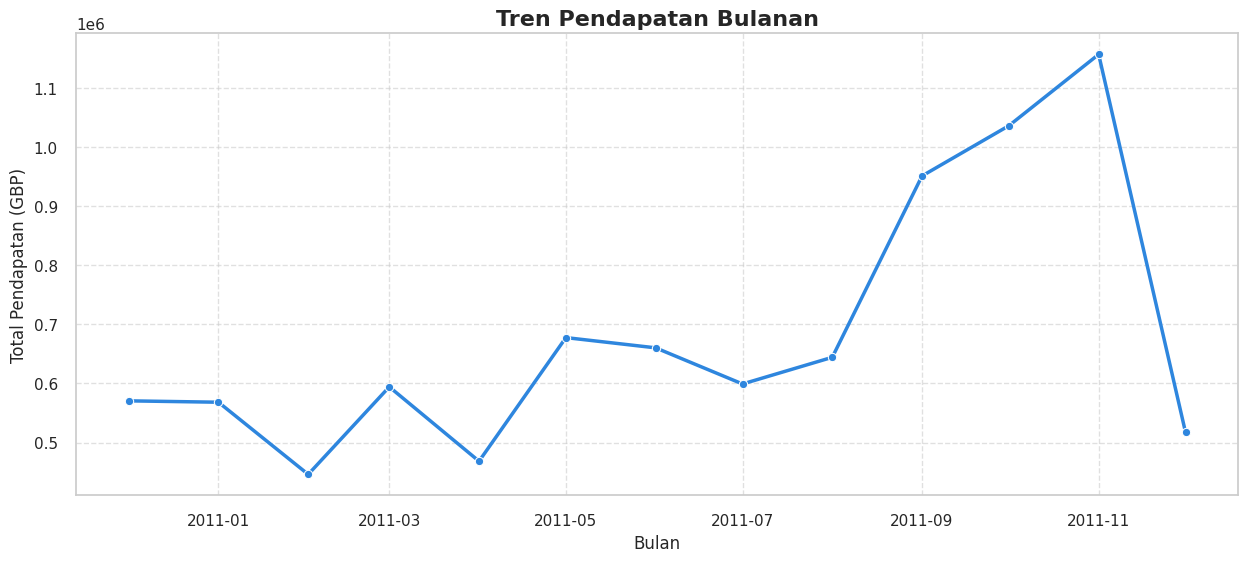

In [4]:
monthly_revenue = df.groupby('Month_Year')['Revenue'].sum().reset_index()
monthly_revenue['Month_Year'] = monthly_revenue['Month_Year'].dt.to_timestamp()

plt.figure(figsize=(15, 6))
sns.lineplot(x='Month_Year', y='Revenue', data=monthly_revenue, marker='o', color='#2e86de', linewidth=2.5)
plt.title('Tren Pendapatan Bulanan', fontsize=16, fontweight='bold')
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Total Pendapatan (GBP)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### 4.2. Produk Terlaris (Best Selling Products)
Kami mengidentifikasi 10 produk teratas berdasarkan **kuantitas terjual** dan **total pendapatan**.

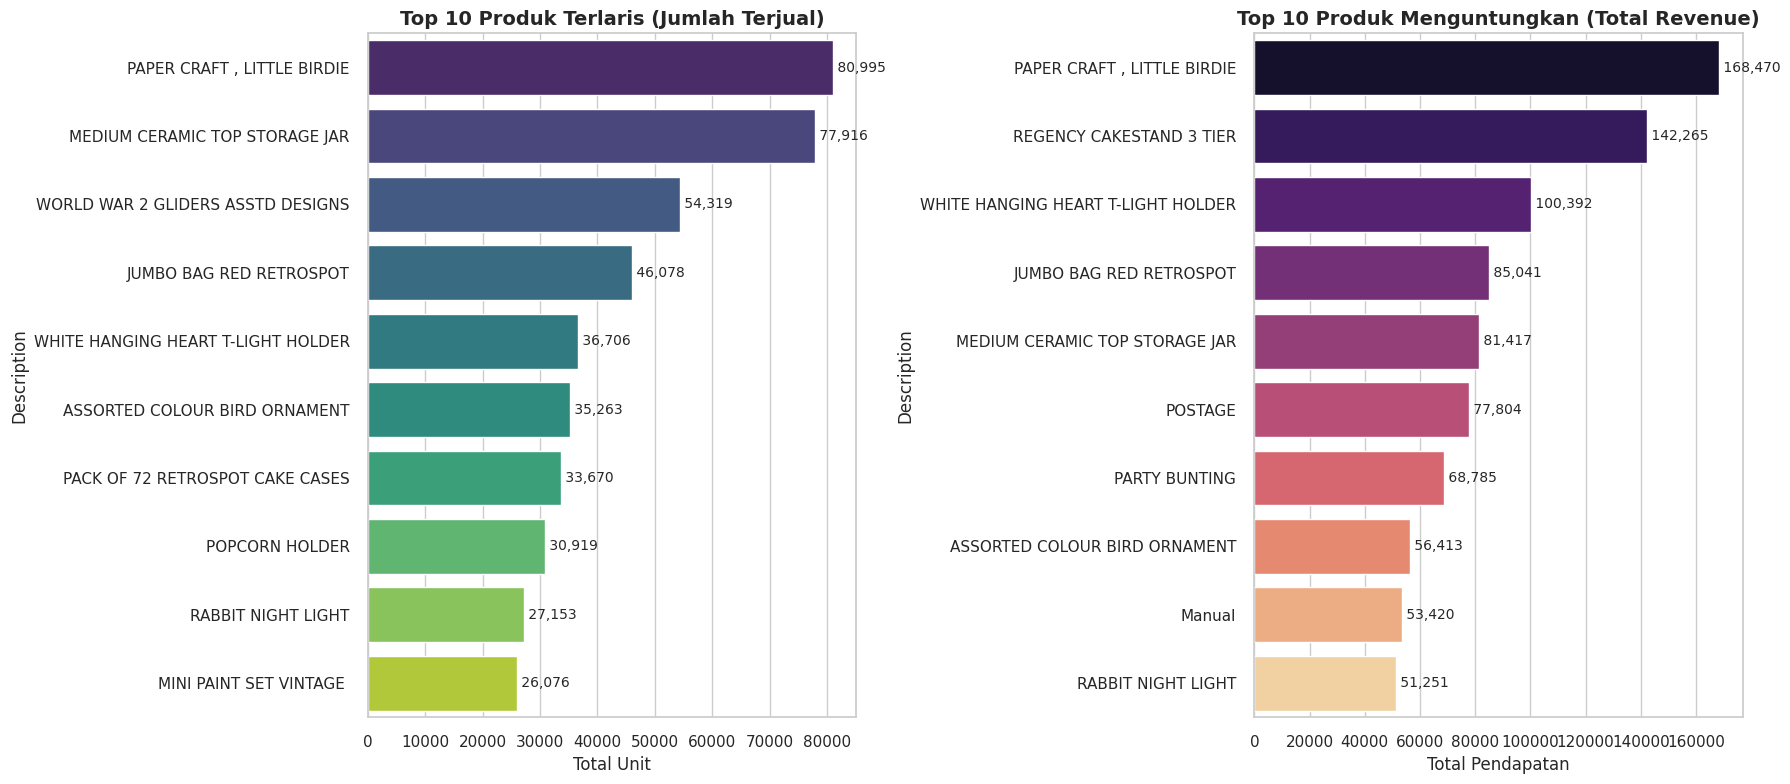

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Top 10 Berdasarkan Kuantitas
top_qty = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_qty.values, y=top_qty.index, ax=axes[0], palette='viridis')
axes[0].set_title('Top 10 Produk Terlaris (Jumlah Terjual)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Total Unit')

# # Menambahkan angka pada label
for i, v in enumerate(top_qty.values):
    axes[0].text(v, i, f' {v:,.0f}', va='center', fontsize=10)

# Plot 2: Top 10 Berdasarkan Revenue
top_rev = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_rev.values, y=top_rev.index, ax=axes[1], palette='magma')
axes[1].set_title('Top 10 Produk Menguntungkan (Total Revenue)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Pendapatan')

# Menambahkan angka pada label
for i, v in enumerate(top_rev.values):
    axes[1].text(v, i, f' {v:,.0f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### 4.3. Distribusi Pasar Berdasarkan Negara
Karena ini adalah dataset transnasional, kami ingin melihat negara mana yang menyumbang pendapatan terbesar selain UK.

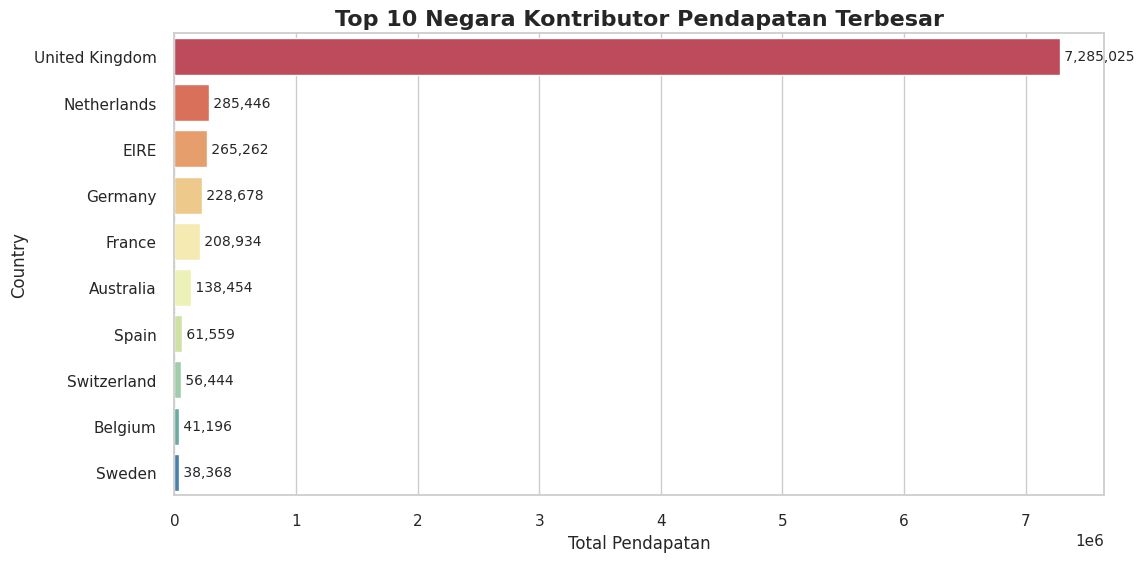

In [6]:
country_rev = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
plot = sns.barplot(x=country_rev.values, y=country_rev.index, palette='Spectral')
plt.title('Top 10 Negara Kontributor Pendapatan Terbesar', fontsize=16, fontweight='bold')
plt.xlabel('Total Pendapatan')

for i, v in enumerate(country_rev.values):
    plot.text(v, i, f' {v:,.0f}', va='center', fontsize=10)

plt.show()

### 4.4. Pola Waktu Belanja (Heatmap)
Untuk mengoptimalkan waktu pengiriman email marketing, kami menganalisis kapan pelanggan paling aktif bertransaksi (Hari vs Jam).

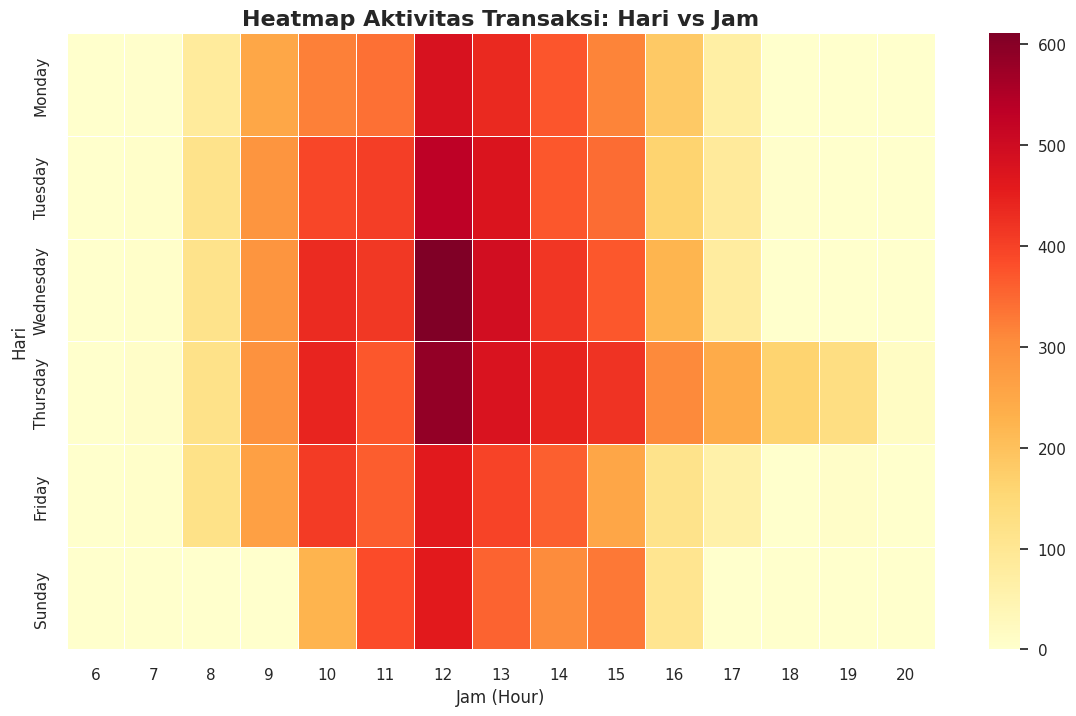

In [7]:
order_pattern = df.groupby(['DayOfWeek', 'Hour'])['InvoiceNo'].nunique().reset_index()
pivot_table = order_pattern.pivot(index='DayOfWeek', columns='Hour', values='InvoiceNo')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=False, linewidths=.5)
plt.title('Heatmap Aktivitas Transaksi: Hari vs Jam', fontsize=16, fontweight='bold')
plt.xlabel('Jam (Hour)', fontsize=12)
plt.ylabel('Hari', fontsize=12)
plt.show()

**Hasil Insights dari EDA:**
1.  **Tren Penjualan:** Terdapat lonjakan signifikan di akhir tahun (November-Desember), kemungkinan besar didorong oleh *Holiday Season* atau persiapan Natal.
2.  **Produk:** Produk dengan performa terbaik didominasi oleh barang kerajinan dan perlengkapan dekorasi kecil, seperti PAPER CRAFT, LITTLE BIRDIE, storage jar, t-light holder, serta retrosport bags. Pola ini menunjukkan bahwa bisnis cenderung berfokus pada produk dekorasi, hadiah kecil, dan barang rumah tangga berdesain unik, yang umum dijual oleh gift shop, toko suvenir, atau retailer dekorasi rumah.
3.  **Geografis:** Mayoritas besar pendapatan berasal dari United Kingdom, namun ada potensi pasar di negara Eropa lain seperti Belanda (Netherlands) dan Jerman (EIRE/Germany).
4.  **Waktu Belanja:** Aktivitas puncak terjadi di tengah hari (pukul 10:00 - 15:00), terutama di hari Kamis. Tidak ada transaksi di hari Sabtu (kemungkinan toko libur operasional).

## 5. RFM Modelling
Untuk memahami profil pelanggan, kami mentransformasi data transaksi menjadi agregasi level pelanggan menggunakan metode **RFM**:

* **Recency (R):** Berapa hari sejak pembelian terakhir pelanggan? (Semakin kecil semakin baik).
* **Frequency (F):** Berapa kali pelanggan melakukan transaksi unik? (Semakin besar semakin baik).
* **Monetary (M):** Berapa total uang yang dibelanjakan pelanggan? (Semakin besar semakin baik).

In [8]:
print('Start date:' , df['InvoiceDate'].min())
print('End date:' , df['InvoiceDate'].max())

Start date: 2010-12-01 08:26:00
End date: 2011-12-09 12:50:00


In [9]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Revenue': 'sum'
}).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Revenue': 'Monetary'
}, inplace=True)

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


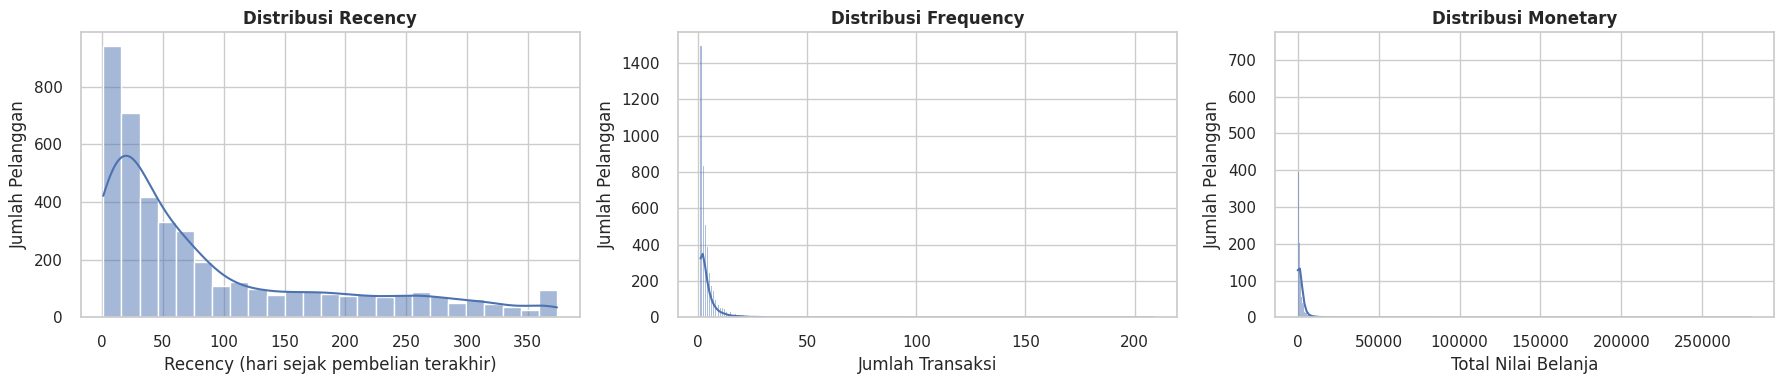

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# Plot Recency
sns.histplot(data=rfm, x='Recency', kde=True, ax=axs[0])
axs[0].set_title("Distribusi Recency", fontsize=12, fontweight='bold')
axs[0].set_xlabel("Recency (hari sejak pembelian terakhir)")
axs[0].set_ylabel("Jumlah Pelanggan")

# Plot Frequency
sns.histplot(data=rfm, x='Frequency', kde=True, ax=axs[1])
axs[1].set_title("Distribusi Frequency", fontsize=12, fontweight='bold')
axs[1].set_xlabel("Jumlah Transaksi")
axs[1].set_ylabel("Jumlah Pelanggan")

# Plot MonetaryValue
sns.histplot(data=rfm, x='Monetary', kde=True, ax=axs[2])
axs[2].set_title("Distribusi Monetary", fontsize=12, fontweight='bold')
axs[2].set_xlabel("Total Nilai Belanja")
axs[2].set_ylabel("Jumlah Pelanggan")

plt.tight_layout()
plt.show()


## 6. Preprocessing untuk K-Means Clustering
Algoritma K-Means sensitif terhadap distribusi data yang condong (skewed) dan perbedaan skala. Oleh karena itu, kami melakukan langkah berikut:

1.  **Analisis Skewness:** Memeriksa distribusi data RFM.

2.  **Transformasi Data:** Menggunakan `Box-Cox` dan `Cubic Root` untuk membuat distribusi data mendekati normal (Gaussian).

3.  **Standardisasi (Scaling):** Menggunakan `StandardScaler` agar semua variabel memiliki skala yang setara (mean=0, std=1).

In [11]:
from scipy.stats import boxcox
def analyze_skewness(col):
    data = rfm[col].copy()

    # Handle zero/negative values for Box-Cox
    shift = 1 if data.min() <= 0 else 0
    data_shifted = data + shift

    # Transformations
    log_trans  = np.log1p(data)
    sqrt_trans = np.sqrt(data)
    cbrt_trans = np.cbrt(data)
    boxcox_trans, _ = boxcox(data_shifted)

    # Plot all transformations
    fig, ax = plt.subplots(2, 3, figsize=(15, 8))

    sns.histplot(data, kde=True, ax=ax[0,0]);
    ax[0,0].set_title("Original")
    sns.histplot(log_trans, kde=True, ax=ax[0,1]);
    ax[0,1].set_title("Log1p")
    sns.histplot(sqrt_trans, kde=True, ax=ax[0,2]);
    ax[0,2].set_title("Square Root")
    sns.histplot(cbrt_trans, kde=True, ax=ax[1,0]);
    ax[1,0].set_title("Cubic Root")
    sns.histplot(boxcox_trans, kde=True, ax=ax[1,1]);
    ax[1,1].set_title("Box-Cox")

    ax[1,2].axis("off")
    plt.tight_layout()
    plt.show()

    print(f"\nSkewness Comparison for {col}")
    print("-" * 40)
    print("Original:     ", round(data.skew(), 3))
    print("Log1p:        ", round(log_trans.skew(), 3))
    print("Sqrt:         ", round(sqrt_trans.skew(), 3))
    print("Cubic Root:   ", round(cbrt_trans.skew(), 3))
    print("Box-Cox:      ", round(pd.Series(boxcox_trans).skew(), 3))

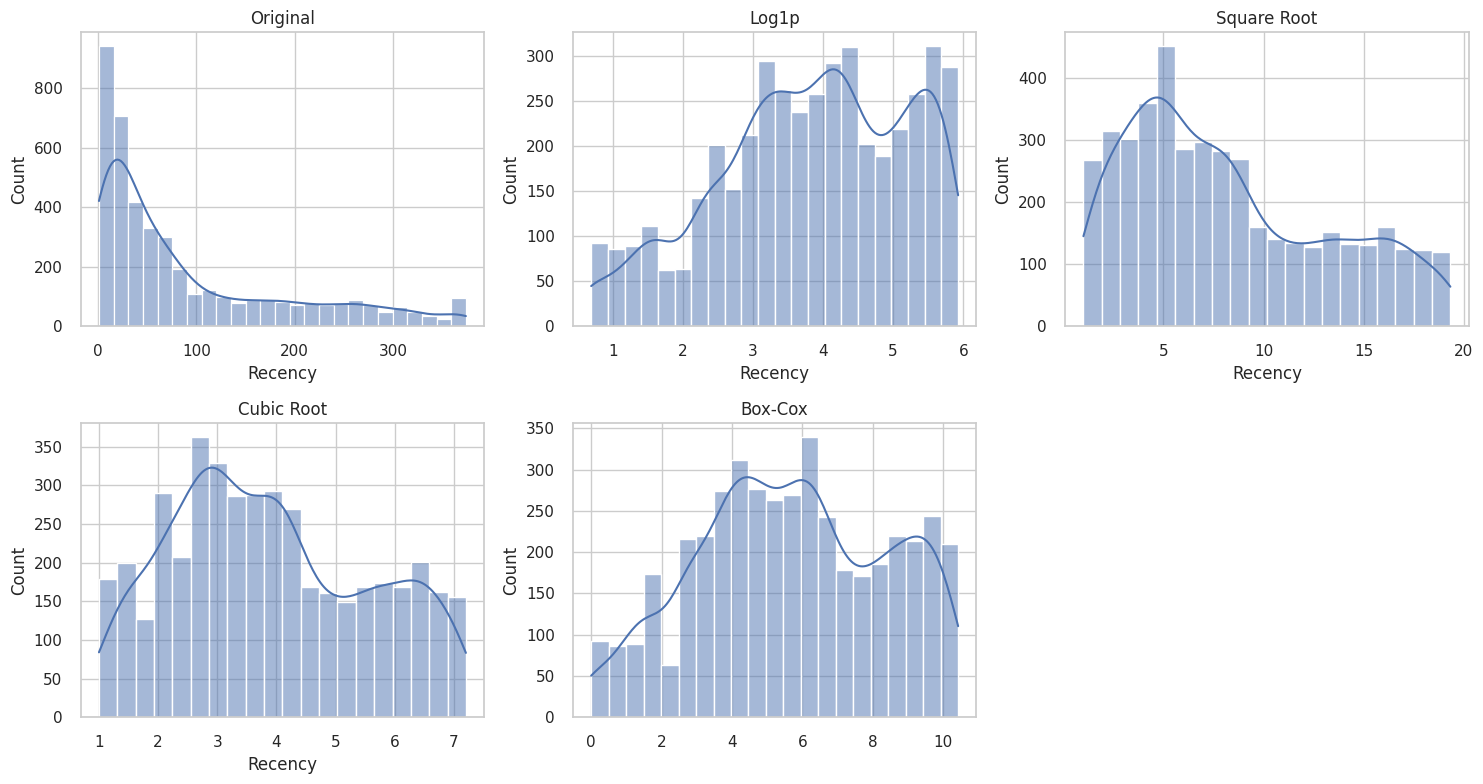


Skewness Comparison for Recency
----------------------------------------
Original:      1.246
Log1p:         -0.379
Sqrt:          0.589
Cubic Root:    0.283
Box-Cox:       -0.07


In [12]:
analyze_skewness('Recency')

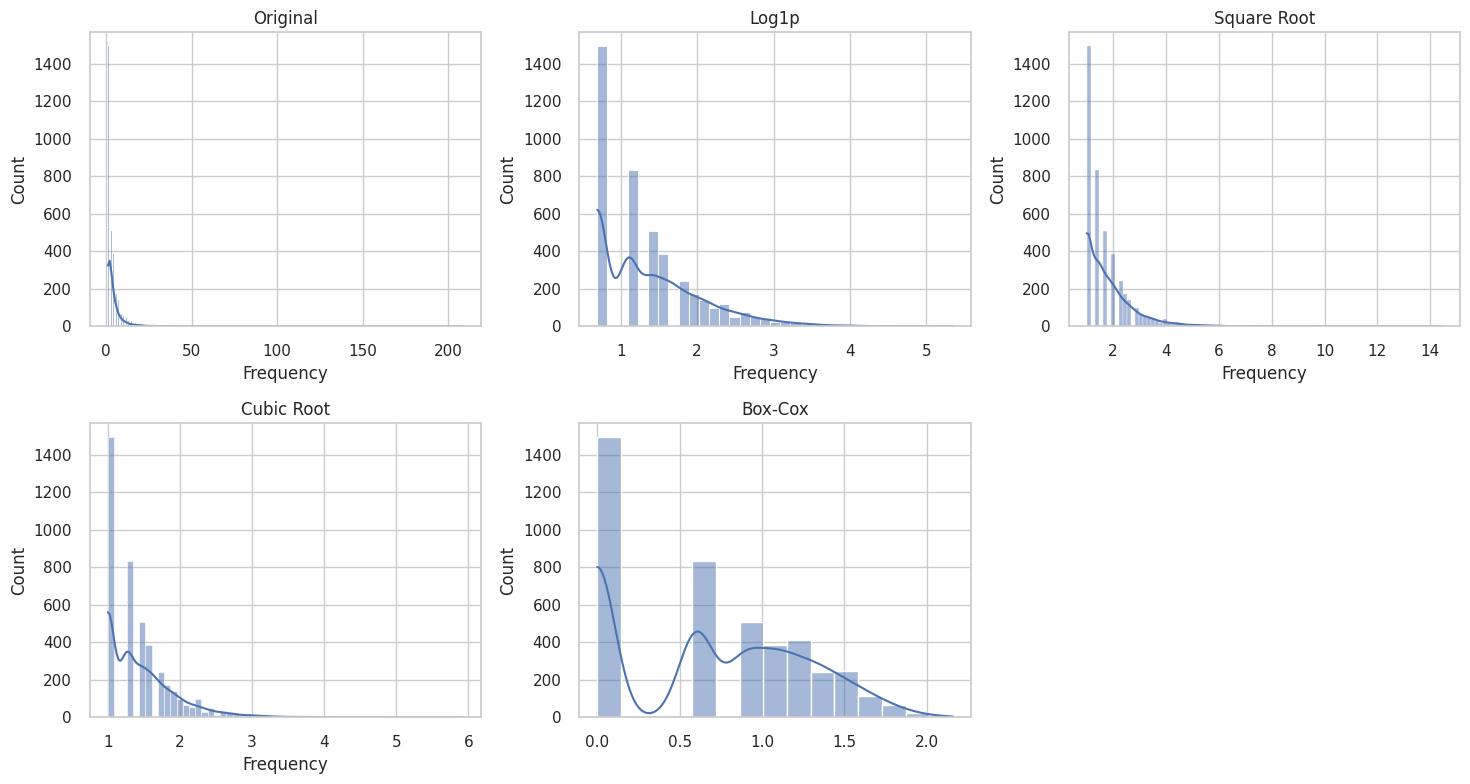


Skewness Comparison for Frequency
----------------------------------------
Original:      12.067
Log1p:         1.209
Sqrt:          3.024
Cubic Root:    1.912
Box-Cox:       0.145


In [13]:
analyze_skewness('Frequency')

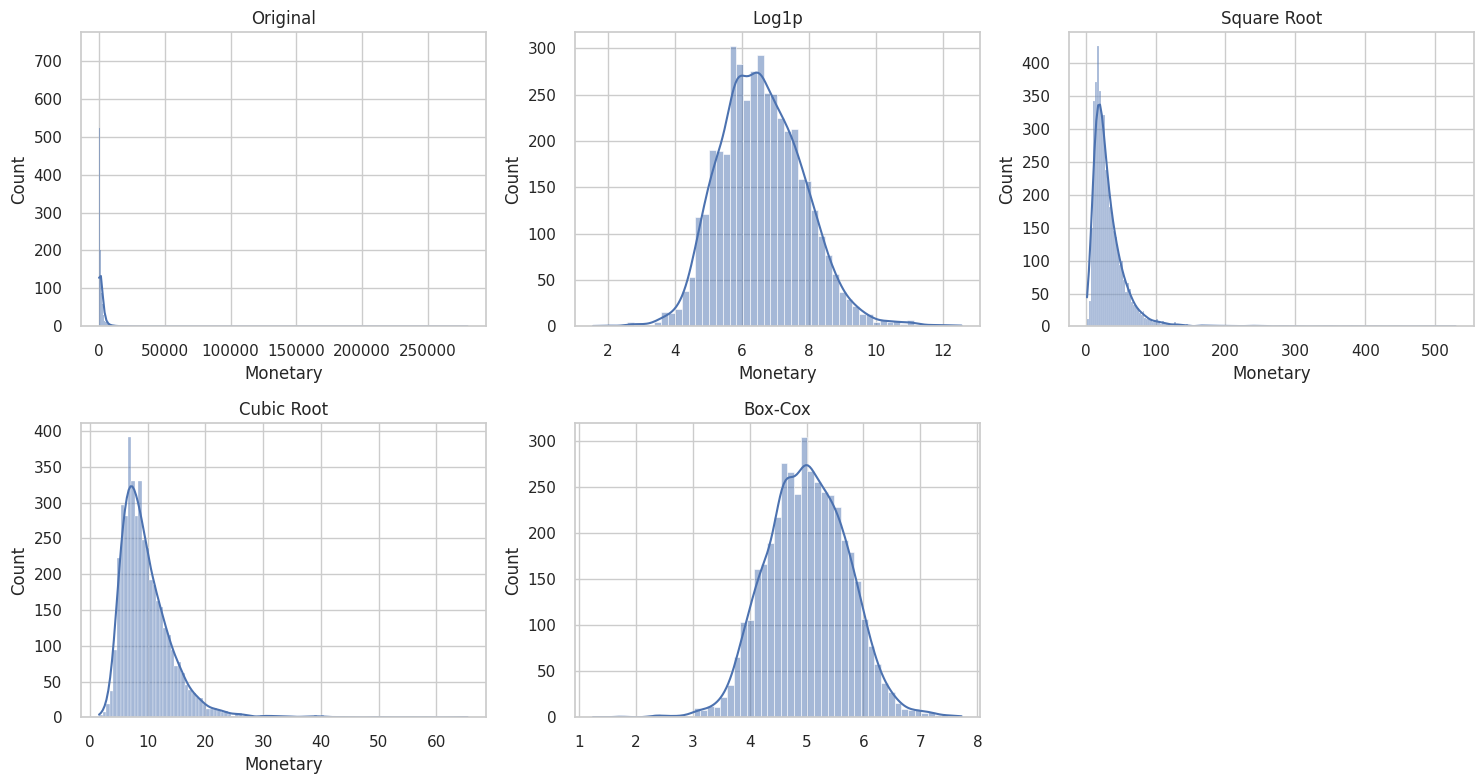


Skewness Comparison for Monetary
----------------------------------------
Original:      19.339
Log1p:         0.397
Sqrt:          5.895
Cubic Root:    3.005
Box-Cox:       -0.016


In [14]:
analyze_skewness('Monetary')

In [15]:
# Transformasi Data (Mengurangi Skewness)
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(rfm['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(rfm['Frequency'])[0]
customers_fix["Monetary"] = pd.Series(np.cbrt(rfm['Monetary'])).values

# Scaling Data
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

# Membuat DataFrame hasil normalisasi
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'Monetary'])
df_normalized['CustomerID'] = rfm['CustomerID']

## 7. K-Means Clustering & Evaluasi
Kami menggunakan **Elbow Method** untuk menentukan jumlah cluster (K) yang paling optimal. Kami mencari titik di mana penurunan *Sum of Squared Errors (SSE)* mulai melambat secara signifikan (membentuk siku).

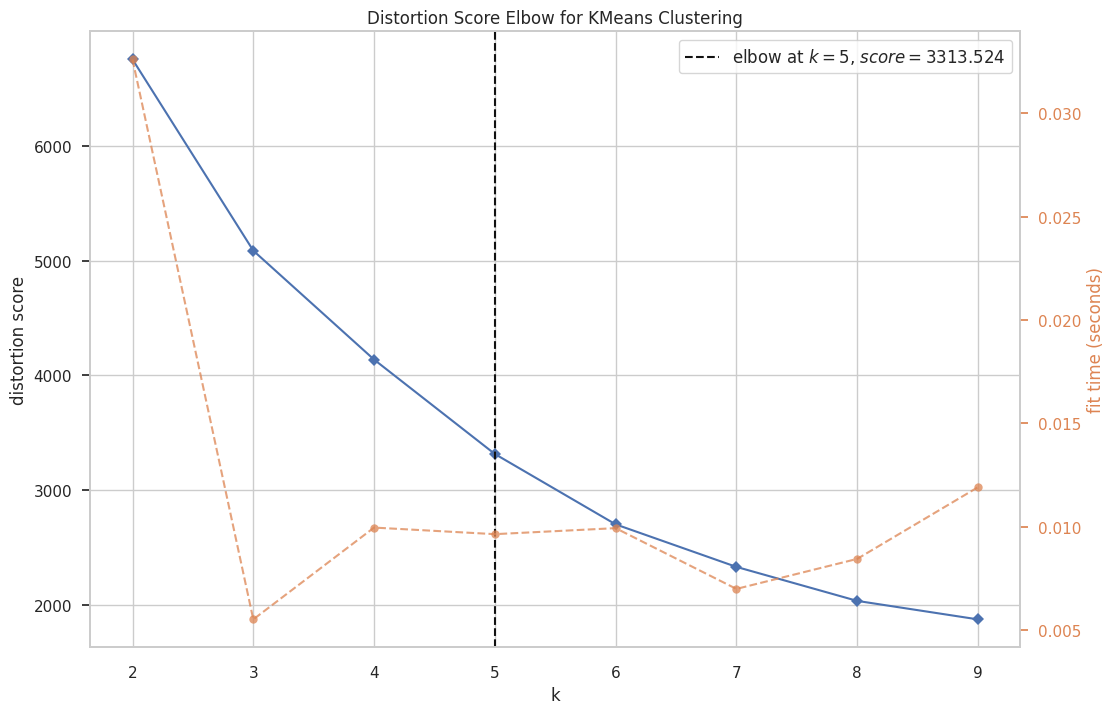

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
plt.figure(figsize=(12, 8))



kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(2, 10))

visualizer.fit(customers_normalized)
visualizer.show()


In [17]:
model = KMeans(n_clusters=5, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(4338,)

In [18]:
rfm["Cluster"] = model.labels_
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,326,1,77183.60,1
1,12347,2,7,4310.00,0
2,12348,75,4,1797.24,3
3,12349,19,1,1757.55,2
4,12350,310,1,334.40,4


In [19]:
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(1)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          17.0       6.9   2381.2  1150
1          15.4      26.0  23721.7   178
2          36.6       1.3    414.0   938
3         100.8       3.3   1121.2  1091
4         239.4       1.1    320.9   981

In [20]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'Monetary'])
df_normalized['ID'] = rfm.index
df_normalized['Cluster'] = model.labels_
df_normalized.head()

,Recency,Frequency,Monetary,ID,Cluster
0,1.624870,-1.184682,6.614538,0,1
1,-1.841636,1.159357,1.295062,1,0
2,0.291210,0.664699,0.462702,2,3
3,-0.679354,-1.184682,0.444467,3,2
4,1.573275,-1.184682,-0.592410,4,4


In [21]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','Monetary'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0,1,Recency,1.624870
1,1,0,Recency,-1.841636
2,2,3,Recency,0.291210
3,3,2,Recency,-0.679354
4,4,4,Recency,1.573275


In [22]:
fig3 = df_nor_melt.groupby('Cluster').agg({'ID': 'count'}).reset_index()
fig3.rename(columns={'ID': 'Count'}, inplace=True)
fig3['percent'] = (fig3['Count'] / fig3['Count'].sum() * 100).round(1)
fig3

,Cluster,Count,percent
0,0,3450,26.5
1,1,534,4.1
2,2,2814,21.6
3,3,3273,25.1
4,4,2943,22.6


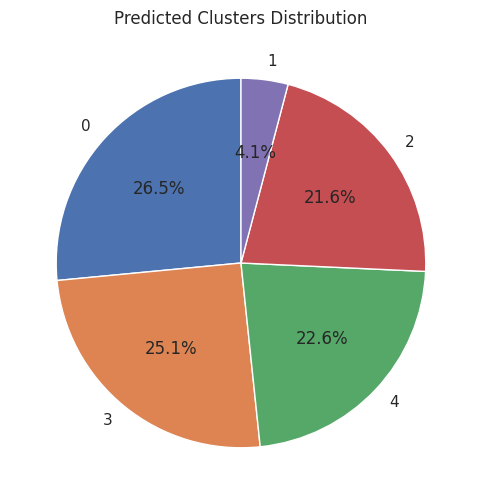

In [26]:
cluster_counts = rfm['Cluster'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(cluster_counts,
        labels=cluster_counts.index,
        autopct='%1.1f%%',
        startangle=90)

plt.title('Predicted Clusters Distribution')
plt.show()

## 8. Customer Profiling & Analisis
Setelah melakukan clustering, kami menganalisis karakteristik setiap segmen. Kami menggunakan **Snake Plot** untuk memvisualisasikan perbandingan nilai atribut RFM yang telah dinormalisasi antar cluster.

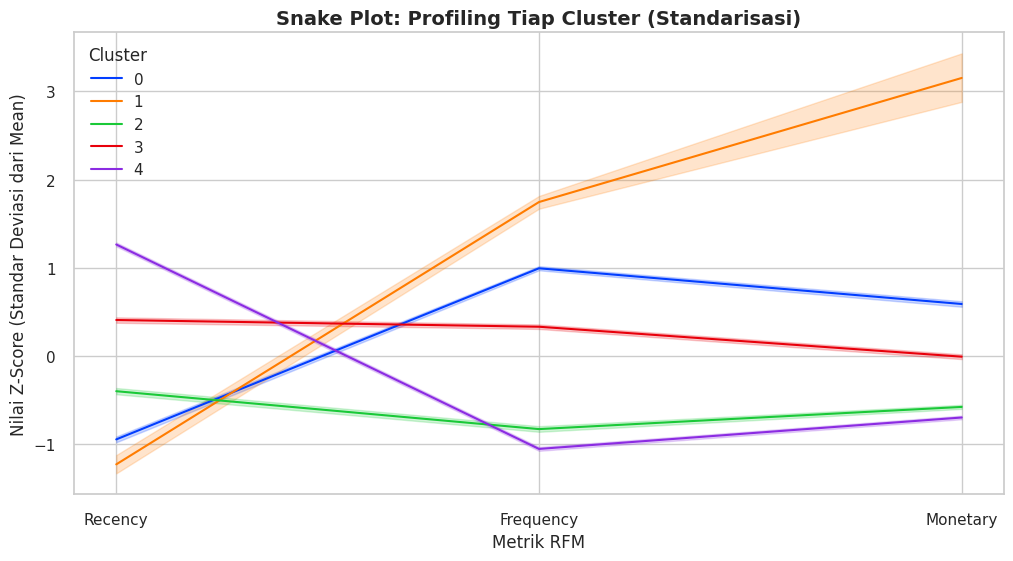

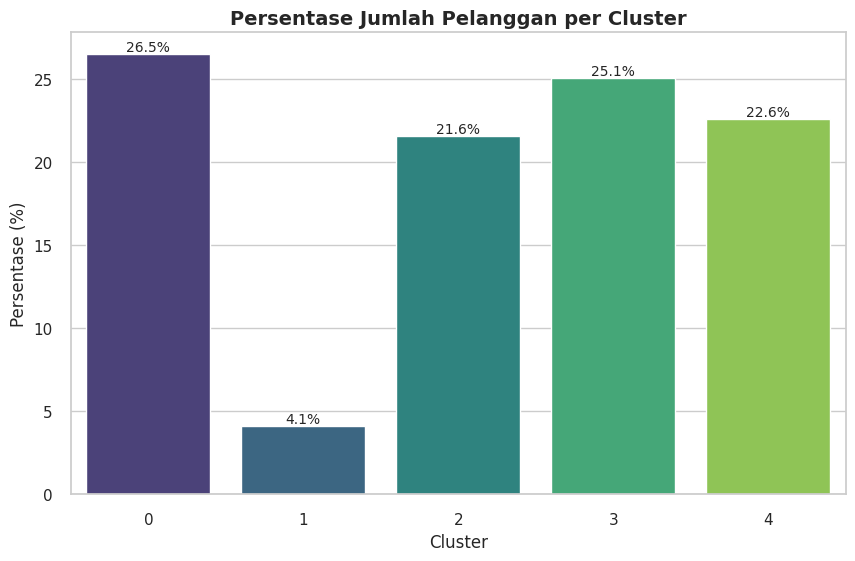

In [24]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_nor_melt, palette='bright')
plt.title('Snake Plot: Profiling Tiap Cluster (Standarisasi)', fontsize=14, fontweight='bold')
plt.xlabel('Metrik RFM')
plt.ylabel('Nilai Z-Score (Standar Deviasi dari Mean)')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
bars = sns.barplot(x='Cluster', y='percent', data=fig3, palette='viridis')

for i, v in enumerate(fig3['percent']):
    bars.text(i, v, f'{v}%', ha='center', va='bottom', fontsize=10)

plt.title('Persentase Jumlah Pelanggan per Cluster', fontsize=14, fontweight='bold')
plt.ylabel('Persentase (%)')
plt.show()

## 9. Kesimpulan dan Rekomendasi Bisnis

Berdasarkan analisis *K-Means Clustering*, kami berhasil mengidentifikasi 5 segmen pelanggan dengan karakteristik unik. Berikut adalah interpretasi dan strategi yang kami rekomendasikan untuk tim bisnis:

| Cluster | Segmen                       | % Populasi | Profil Singkat                                               | Rekomendasi Strategis                                                                                       |
| ------- | ---------------------------- | ---------- | ------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------- |
| **1**   | **Champions (VIP)**       | **4.1%**   | Belanja sangat sering, nilai belanja terbesar, paling loyal. | **Berikan perlakuan istimewa.** Akses produk lebih cepat, layanan prioritas, dan reward eksklusif. Fokus pada hubungan, bukan diskon. |
| **0**   | **Loyal / Potential VIP** | **26.5%**  | Rutin belanja, nilai cukup besar, interaksi stabil.          | **Dorong naik kelas menjadi VIP.** Berikan bundle menarik, program loyalitas bertingkat, dan rekomendasi produk yang lebih personal.  |
| **3**   | **At Risk**               | **25.1%**  | Dulu aktif, sekarang jarang muncul.                          | **Ajak kembali secara personal.** Kirim pesan ramah “Kami merindukan Anda” dengan penawaran ringan untuk memancing mereka kembali.    |
| **2**   | **New Customers**         | **21.6%**  | Masih baru, frekuensi rendah, nilai belanja kecil.           | **Bangun kebiasaan belanja.** Tawarkan panduan produk, rekomendasi sesuai minat, dan voucher pembelian kedua.                         |
| **4**   | **Lost / Hibernating**    | **22.6%**  | Lama tidak belanja dan nilai historis rendah.                | **Jangan keluarkan banyak biaya.** Cukup kirim survei singkat atau info promo ringan. Fokuskan energi ke segmen lain.                 |


--------------------------------------------------------------------------
**Kesimpulan Akhir:**
Analisis ini menunjukkan bahwa ~30% pelanggan teratas (Cluster 1 & 0) menyumbang mayoritas nilai transaksi. Strategi perusahaan harus difokuskan untuk mempertahankan kepuasan kelompok ini, lalu dapat mencoba mengaktifkan kembali kelompok At Risk (Cluster 3) agar tidak berpindah ke pesaing.